In [1]:
#https://nlpforhackers.io/wordnet-sentence-similarity/
import re
import csv
import json
import gensim
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import scipy.interpolate as interpolate
from operator import itemgetter
from scipy import stats
from itertools import groupby
from collections import Counter
from gensim.models import LdaModel
#from stop_words import get_stop_words
from nltk import pos_tag
from IPython.display import clear_output
from multiprocessing.pool import ThreadPool
from sklearn.feature_extraction.text import TfidfVectorizer
import concurrent.futures
from nltk.corpus import stopwords as nltk_stop_words, wordnet as wn
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from scipy.interpolate import spline
import warnings
warnings.filterwarnings('ignore')
folder_path = 'D:/MS CS/RS DATA/dataset/HSRank/'
tokenizer = RegexpTokenizer(r'\w+')
print("success")

success


In [ ]:
rs_data_set = pd.read_json(folder_path+'set_rs.json', orient='records', encoding='utf8', lines=True)
group_rs_data_set = rs_data_set.groupby("year")
print("success")

### Operations on topics
#### -> LDA title 100 topics

In [ ]:
# generate LDA model
number_of_topics = 100
number_of_words = 10

texts = [t['title'] for k, t in rs_data_set.iterrows()]

# turn our tokenized documents into a id <-> term dictionary
dictionary = gensim.corpora.Dictionary(texts)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = LdaModel(corpus=corpus, num_topics=number_of_topics, id2word=dictionary)
#ldatopics = ldamodel.show_topics(num_words=25, formatted=False)

top_words_per_topic = []
for t in range(ldamodel.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in ldamodel.show_topic(t, topn = number_of_words)])

lda_topics = []
for key, topic in itertools.groupby(top_words_per_topic, key=itemgetter(0)):
    data = {}
    data['id'] = 'Topic-'+str(key+1)
    data['title'] = [t[1] for t in topic]
    lda_topics.append(data)

print(number_of_topics,"Topics and",number_of_words,"words successfully generated...")

with open(folder_path+'lda-title-topics.json', 'w+', encoding='utf8') as outfile:
    for lda_topic in lda_topics:
        outfile.write(json.dumps(lda_topic)+'\n')
    outfile.close()

### LDA Papers 500 topics

In [ ]:
# generate LDA model
number_of_topics = 100
number_of_words = 20
lda_paper_topics = []
for k, v in group_rs_data_set:

    texts = [t['title'] for k, t in v.iterrows()]

    # turn our tokenized documents into a id <-> term dictionary
    dictionary = gensim.corpora.Dictionary(texts)

    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    ldamodel = LdaModel(corpus=corpus, num_topics=number_of_topics, id2word=dictionary)
    #ldatopics = ldamodel.show_topics(num_words=25, formatted=False)

    top_words_per_topic = []
    for t in range(ldamodel.num_topics):
        top_words_per_topic.extend([(t, ) + x for x in ldamodel.show_topic(t, topn = number_of_words)])

    for key, topic in itertools.groupby(top_words_per_topic, key=itemgetter(0)):
        data = {}
        data['year'] = k
        data['id'] = str(k)+'-'+str(key+1)
        data['title'] = [t[1] for t in topic]
        lda_paper_topics.append(data)

    print(number_of_topics,"Topics and",number_of_words,"words successfully generated...")

pd.DataFrame(lda_paper_topics).to_json(folder_path+'lda_paper_topics.json', orient='records', lines=True)
print("success")

### Read title-topics

In [ ]:
#Read LDA topics file if needs
lda_topics = []
with open(folder_path+'lda-title-topics.json','r', encoding='utf8') as f:
    for doc in f:
        lda_topics.append(json.loads(doc))
    f.close()
print(len(lda_topics), "Topics successfully readed...")

### Read papers-topics

In [ ]:
lda_paper_topics = []
with open(folder_path+'lda_paper_topics.json','r', encoding='utf8') as f:
    for doc in f:
        lda_paper_topics.append(json.loads(doc))
    f.close()
print(len(lda_paper_topics), "Topics successfully readed...")

### Read set_rs

In [ ]:
rs_corpus = []
with open(folder_path+'set_rs.json','r', encoding='utf8') as f:
    for doc in f:
        rs_corpus.append(json.loads(doc))
    f.close()
print(len(rs_corpus), "Topics successfully readed...")

In [ ]:
vs_corpus = []
with open(folder_path+'set_vs.json','r', encoding='utf8') as f:
    for doc in f:
        vs_corpus.append(json.loads(doc))
    f.close()
print(len(vs_corpus), "Topics successfully readed...")

### Following data processing operations are performed
#### 1) Check similarity of topics
#### 2) Get score of topics of each year e.g. 2005, 2006, 2007, 2008 and 2009

In [ ]:
def penn_to_wn(tag):
    if tag.startswith('N'):
        return 'n'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('J'):
        return 'a'
    elif tag.startswith('R'):
        return 'r'
    else:
        return None
    
def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
    #elif wn_tag is 'v':
        #return ''
 
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None

def get_sentence_synset(doc):
    # Tokenize and tag
    #sentence = pos_tag(tokenizer.tokenize(doc['title']))
    sentence = pos_tag(doc['title'])
    
    # Get the synsets for the tagged words
    synsets = [tagged_to_synset(*tagged_word) for tagged_word in sentence]
    
    synsets_index = [i for i in range(len(synsets)) if synsets[i] is None]
    synsets_technical = [sentence[ip][0] for ip in synsets_index]
    
    # Filter out the Nones
    synsets = [ss for ss in synsets if ss]
    
    data = {}
    data['id'] = doc['id']
    data['tech'] = synsets_technical
    data['syn'] = synsets
    return data

def get_sentence_synsets(doc):
    # Tokenize and tag
    #sentence = pos_tag(tokenizer.tokenize(doc['title']))
    sentence = pos_tag(doc['title'])
    
    # Get the synsets for the tagged words
    synsets = [tagged_to_synset(*tagged_word) for tagged_word in sentence]
    
    synsets_index = [i for i in range(len(synsets)) if synsets[i] is None]
    synsets_technical = [sentence[ip][0] for ip in synsets_index]
    
    # Filter out the Nones
    synsets = [ss for ss in synsets if ss]
    
    data = {}
    data['id'] = doc['id']
    data['year'] = doc['year']
    data['tech'] = synsets_technical
    data['syn'] = synsets
    return data

syn_lda_topic = []
syn_rs_set = []
syn_vs_set = []
syn_rs_set_paper = []
if __name__ == "__main__":
    
    pool = ThreadPool(4)
    print("Synset preprocessing has been started...")
    syn_lda_topic = pool.starmap(get_sentence_synset, zip(lda_topics))
    print('Topics completed...')
    syn_rs_set = pool.starmap(get_sentence_synsets, zip(rs_corpus))
    #syn_vs_set = pool.starmap(get_sentence_synsets, zip(vs_corpus))
    print('rs_corpus completed...')
    #syn_rs_set_paper = pool.starmap(get_sentence_synsets, zip(lda_paper_topics))
    print('lda_paper_topics completed...')
    pool.close() 
    pool.join()
    print("Synset has been successfully measured and saved...")

In [ ]:
print(len(lda_topics))
print(len(syn_rs_set_paper))
print(len(syn_rs_set))
print(len(syn_vs_set))

In [ ]:
outfile_paper_similarity = open(folder_path+'paper-similarity-corpus.csv', 'w', newline='')
#outfile_paper_similarity = open(folder_path+'topic-similarity-corpus.csv', 'w', newline='')
#outfile_paper_similarity = open(folder_path+'vs-paper-similarity-corpus.csv', 'w', newline='')
paper_sim_writer = csv.writer(outfile_paper_similarity, quoting=csv.QUOTE_ALL)

def write_paper_similarity(paper_rows):
    paper_sim_writer.writerows(paper_rows)
    outfile_paper_similarity.flush()
    
def get_topic_similarity(topic):
    
    c = 0
    similarity_lst = []
    #for row in syn_rs_set:
    for row in syn_rs_set:
        
        synsets1 = topic['syn']
        synsets2 = row['syn']
        synsets1_technical = topic['tech']
        synsets2_technical = row['tech']

        score = 0.0
        count = 0

        for itech in synsets2_technical:
            if itech in synsets1_technical:
                score += 1
                count += 1
        
        # For each word in the first sentence
        for synset in synsets2:

            # Get the similarity value of the most similar word in the other sentence
            best_score = 0.0
            for ss in synsets1:
                b_score = synset.path_similarity(ss)
                if b_score:
                    if b_score>best_score:
                        best_score = b_score

            if best_score>0.0:
                score += best_score
                count += 1
                
        if count == 0:
            count = 1
        similarity_lst.append([topic['id'], row['id'], row['year'], (score/count)])
        c += 1
        clear_output()
        print(c)

        if c > 4999:
            threading.Thread(target=write_paper_similarity, args=(similarity_lst,)).start() 
            similarity_lst.clear()
            c = 0
        
    threading.Thread(target=write_paper_similarity, args=(similarity_lst,)).start()


if __name__ == "__main__":
    
    #pool = ThreadPool(4)
    print("similarity preprocessing has been started...")
    #pool.starmap(get_topic_similarity, zip(syn_lda_topic))
    #pool.close() 
    #pool.join()
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        for row in syn_lda_topic:
            executor.submit(get_topic_similarity, row)
    print("similarity has been successfully measured and saved")

### Following data processing operations are performed
#### 1) Check topics is hot or not

In [2]:
df_topic_similarity = pd.read_csv(folder_path+'topic-similarity-corpus.csv', names=['tid', 'pid', 'year', 'sim'])
grouped_topic_similarity = df_topic_similarity.groupby(['tid'])
print("success")

success


Total number of Hot topics are 20 ,all another topics can't fulfill criteria


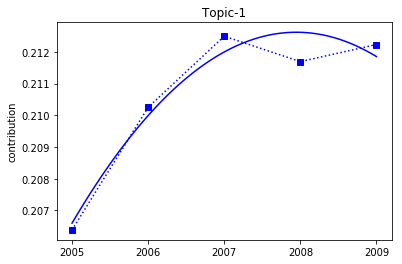

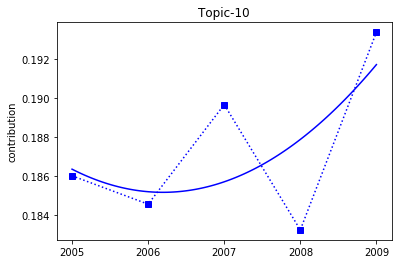

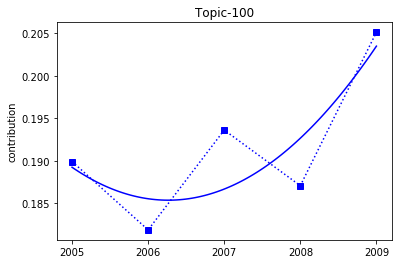

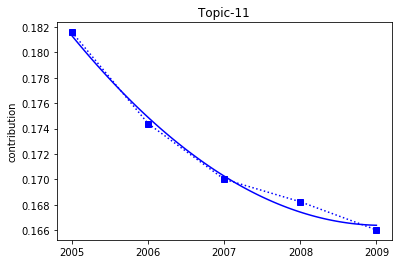

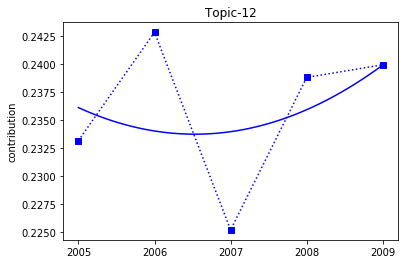

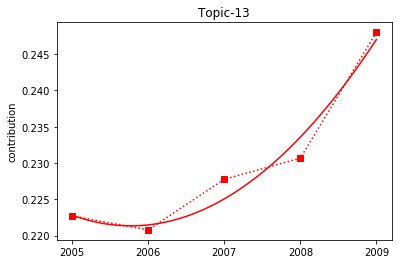

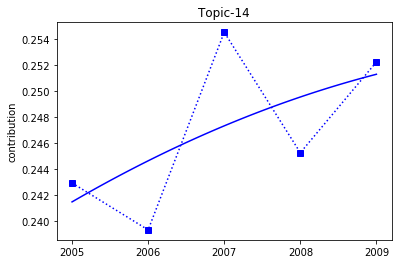

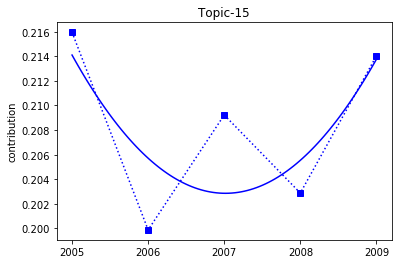

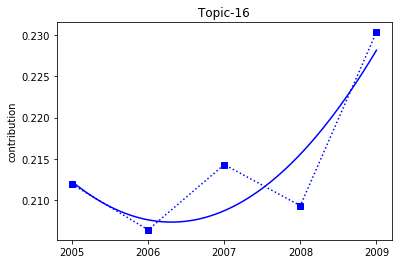

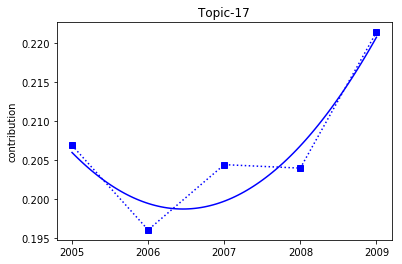

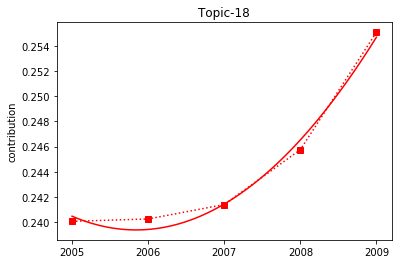

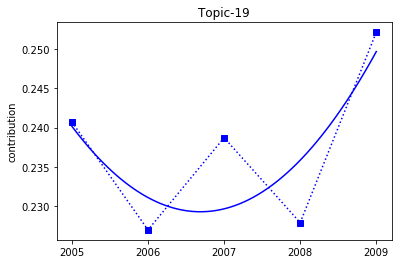

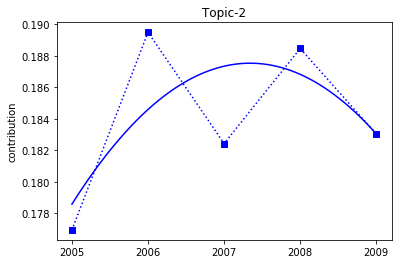

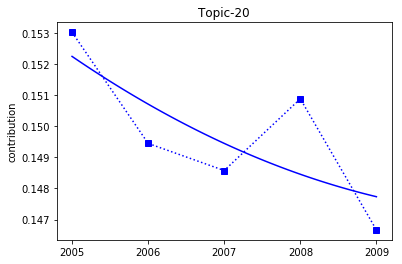

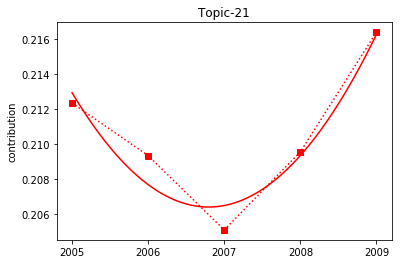

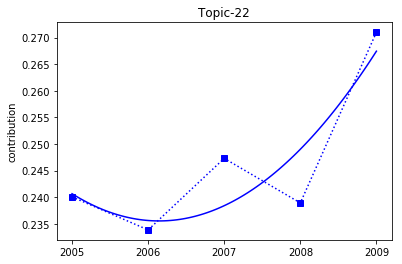

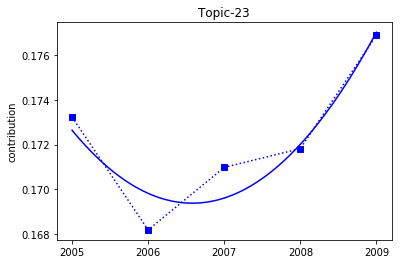

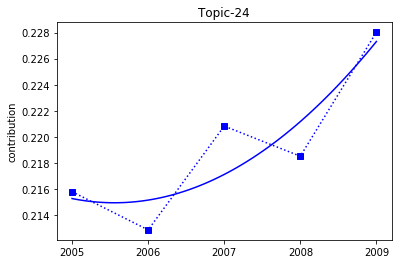

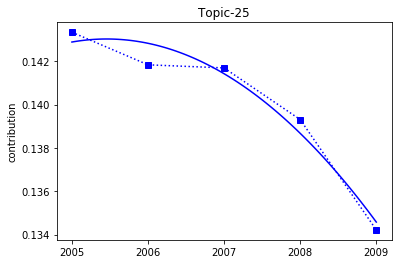

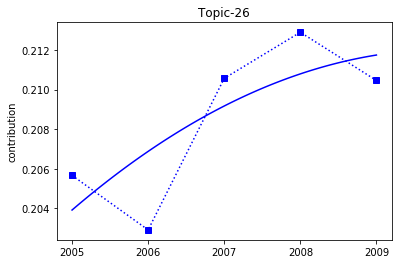

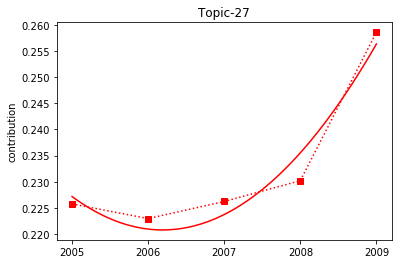

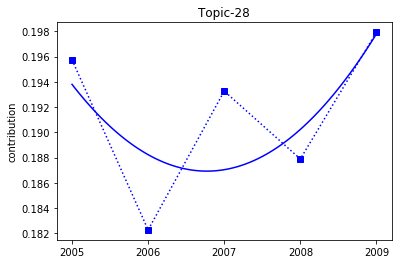

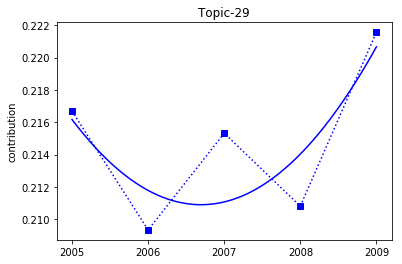

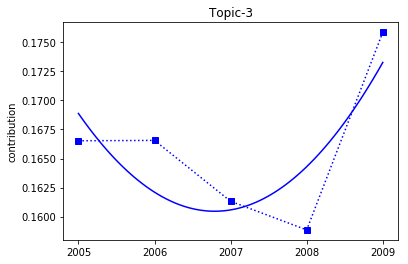

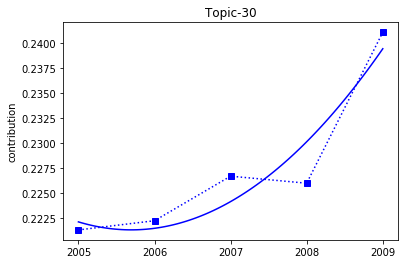

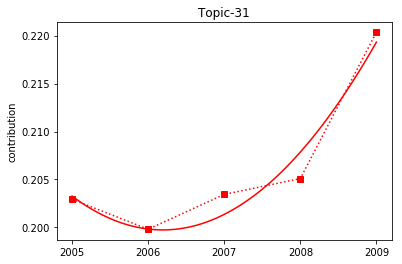

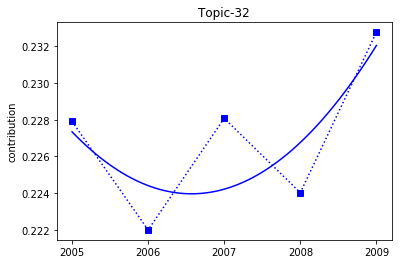

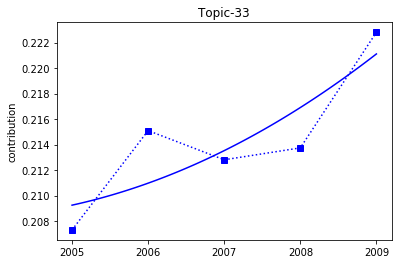

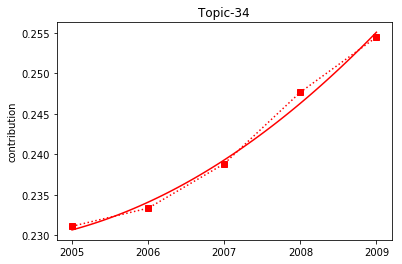

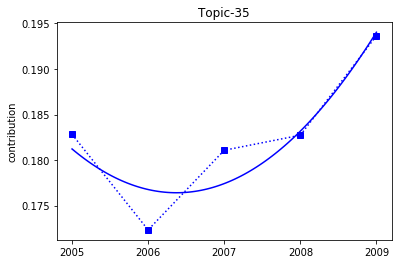

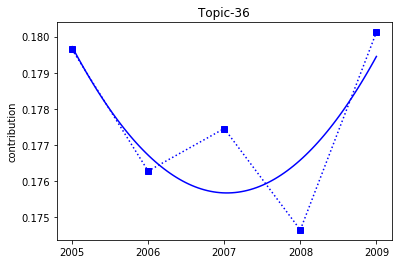

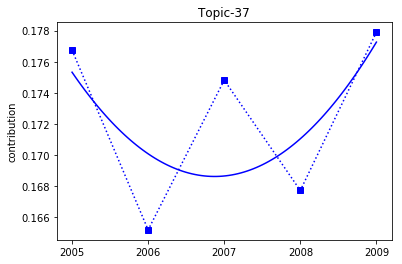

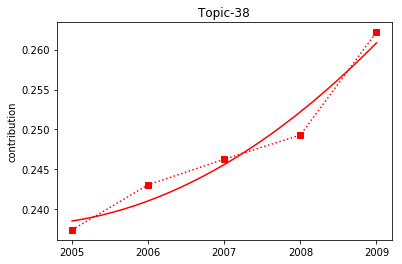

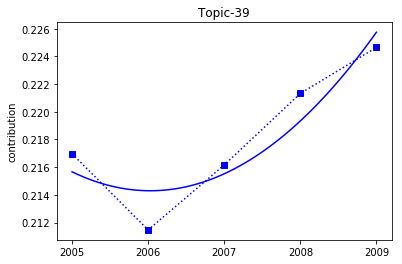

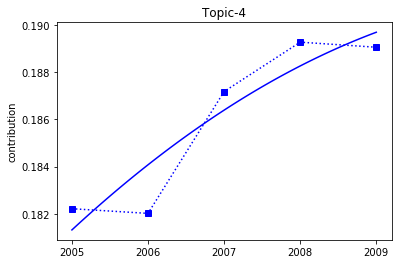

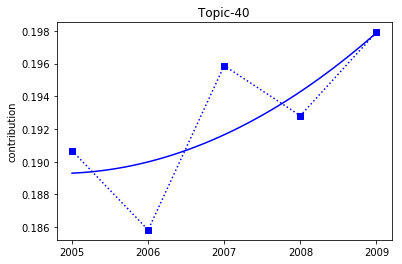

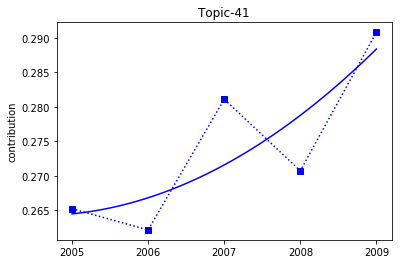

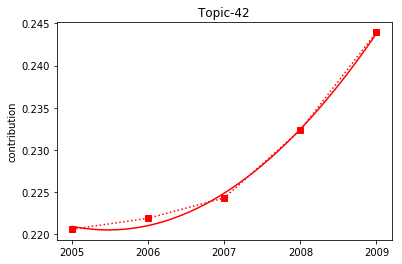

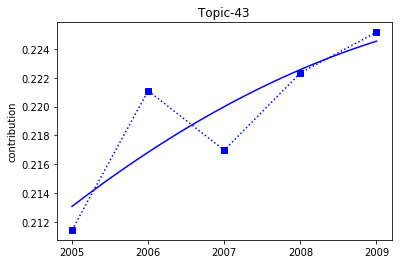

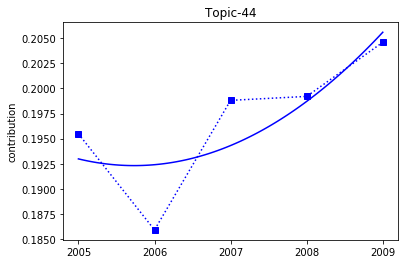

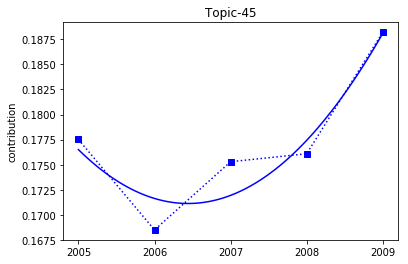

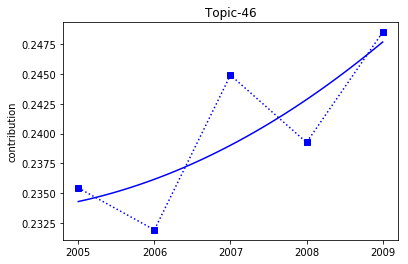

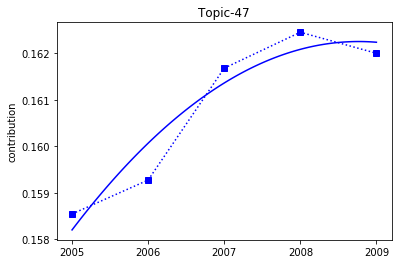

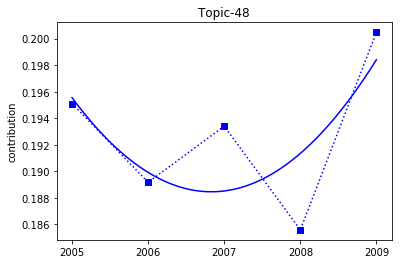

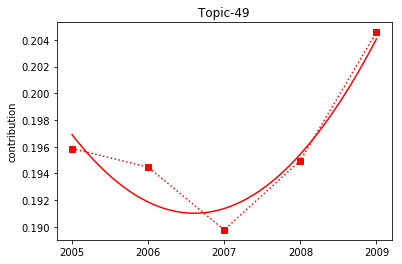

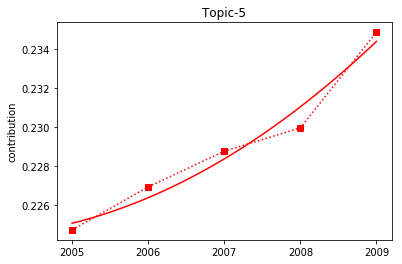

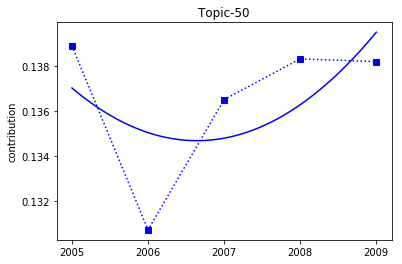

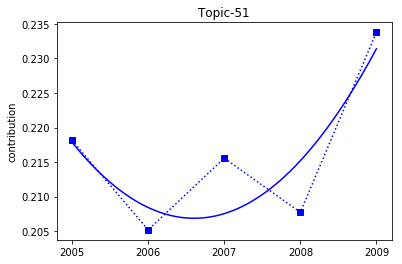

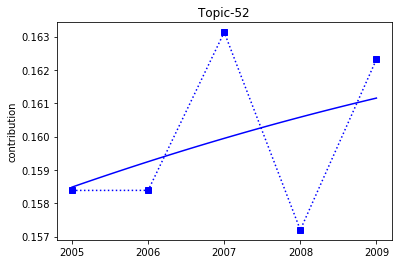

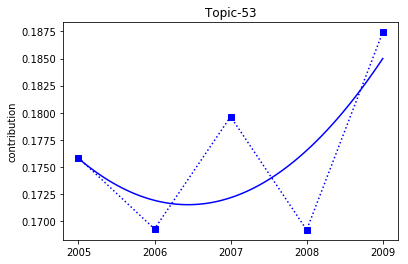

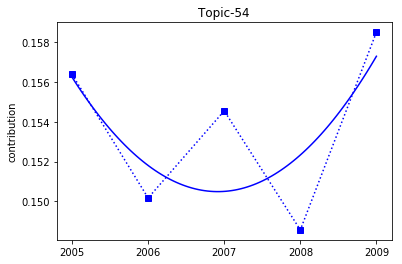

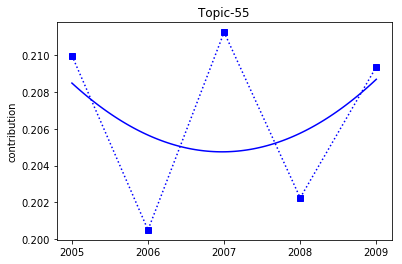

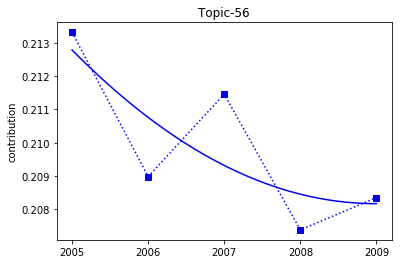

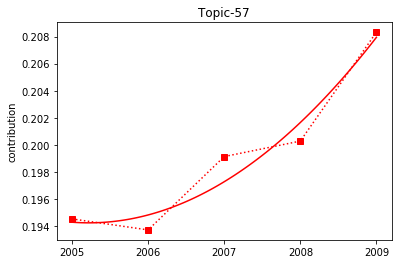

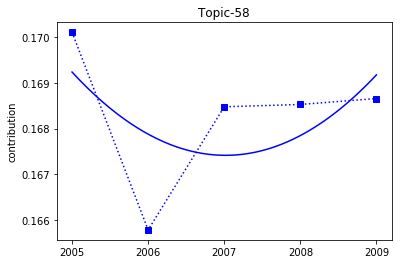

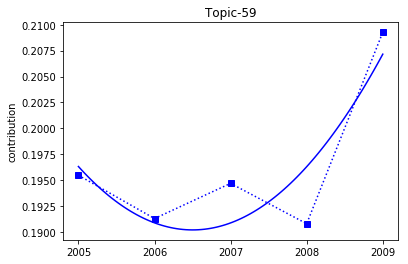

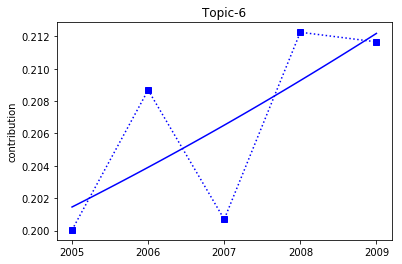

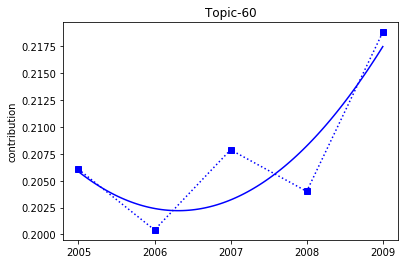

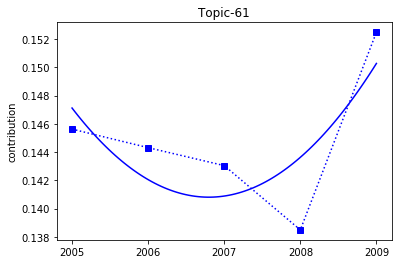

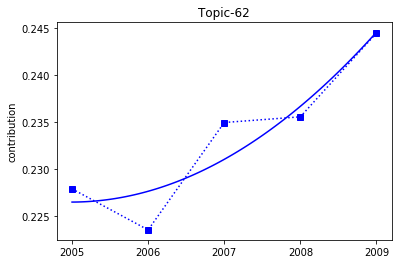

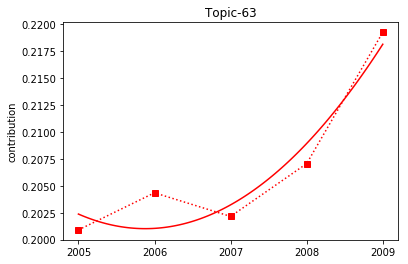

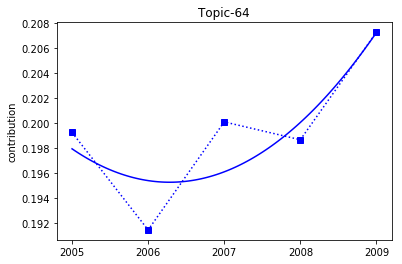

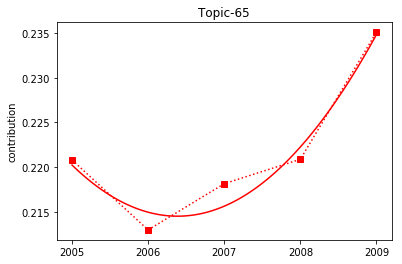

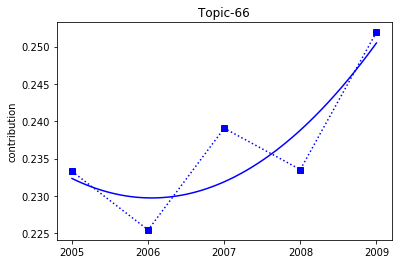

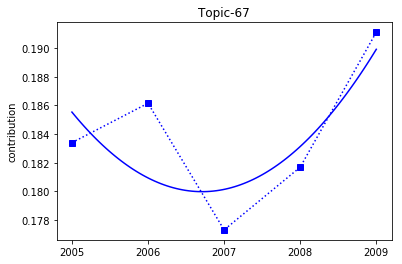

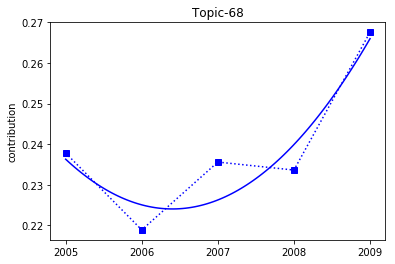

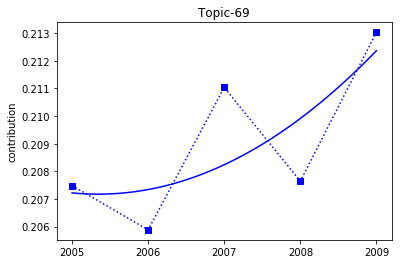

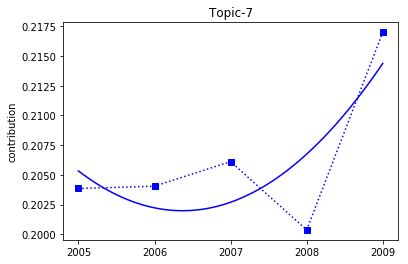

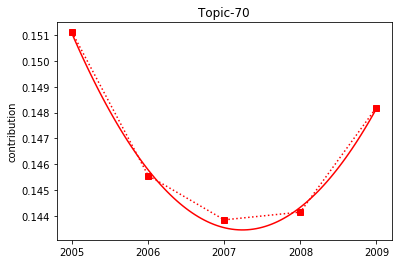

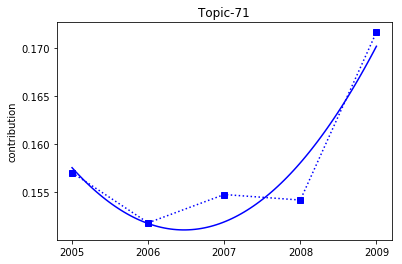

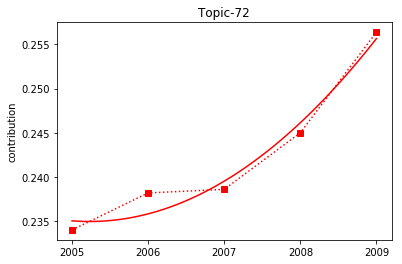

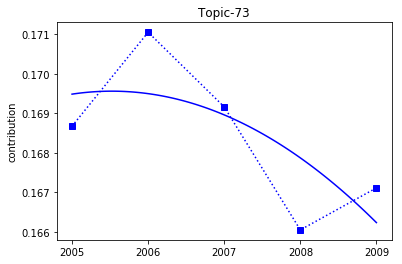

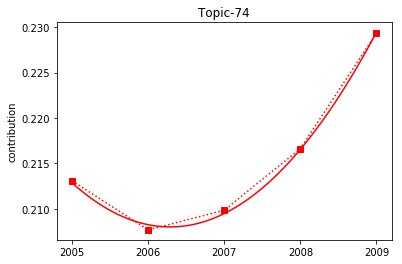

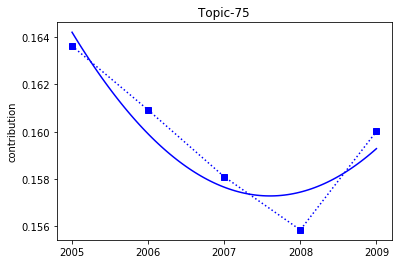

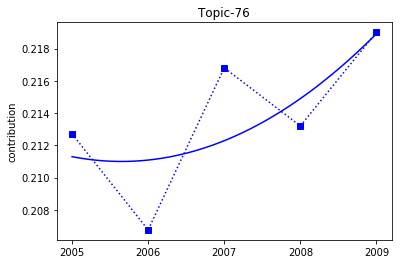

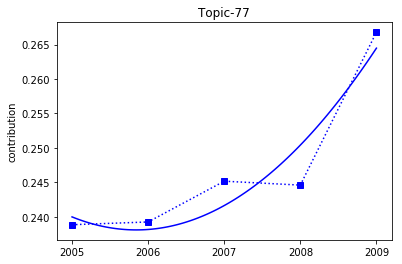

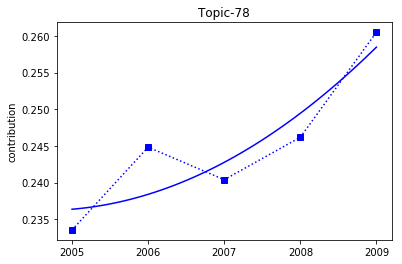

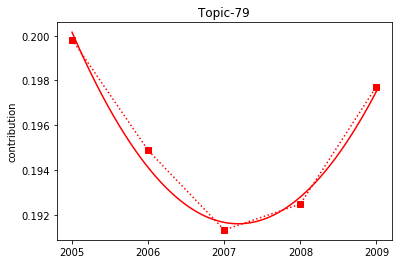

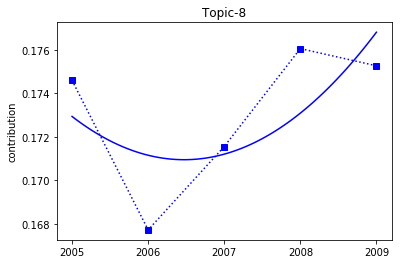

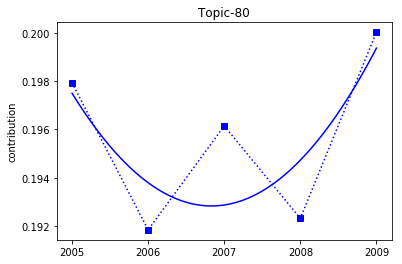

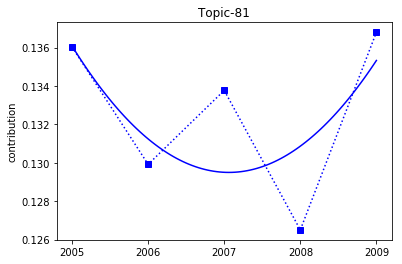

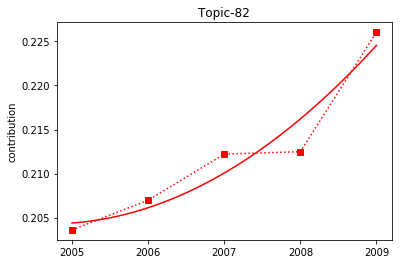

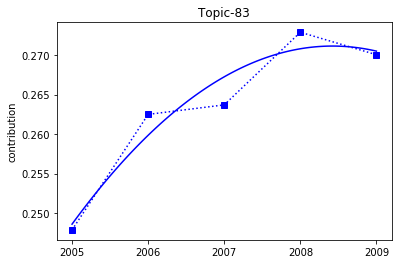

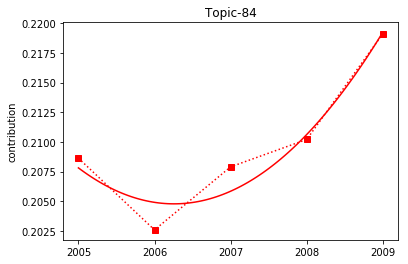

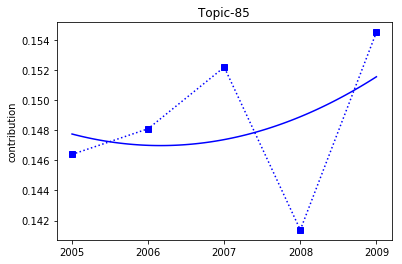

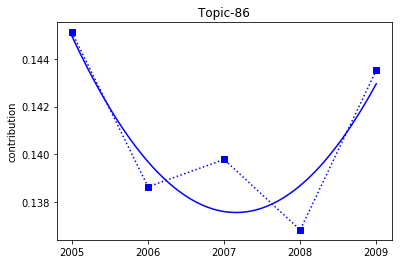

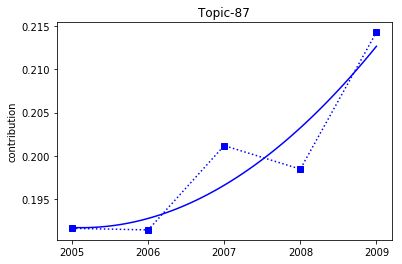

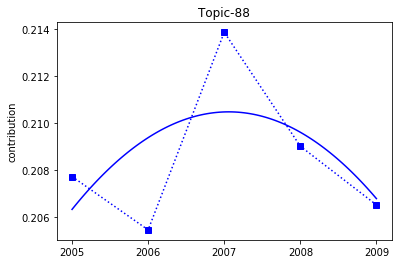

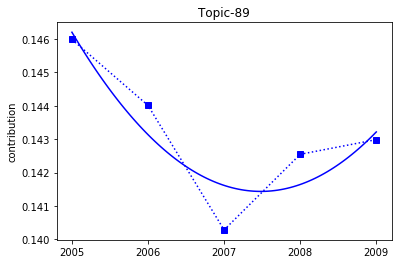

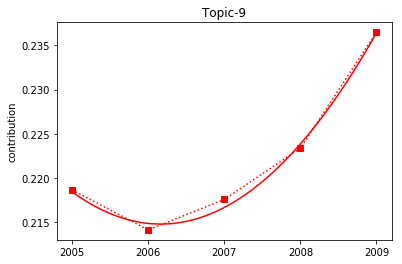

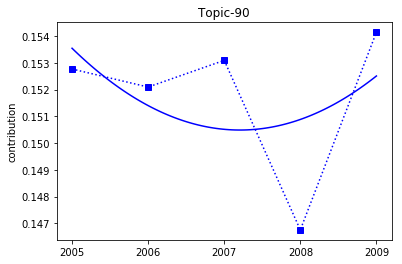

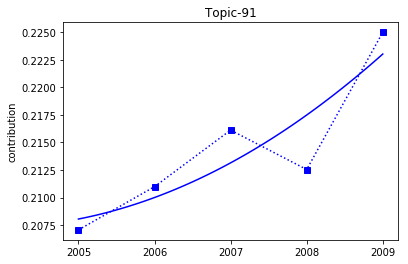

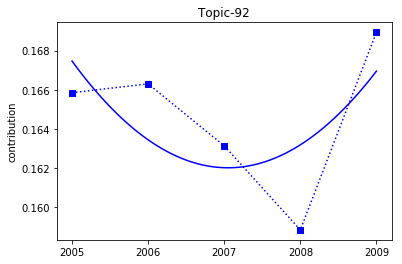

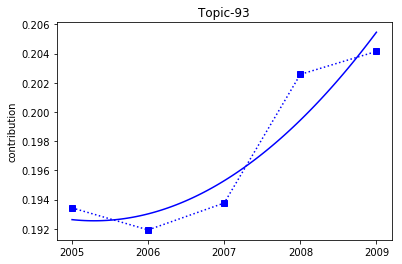

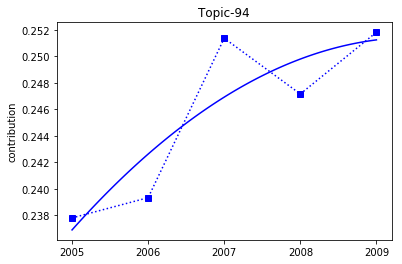

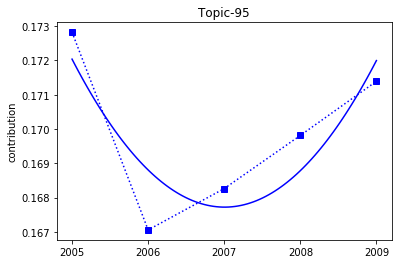

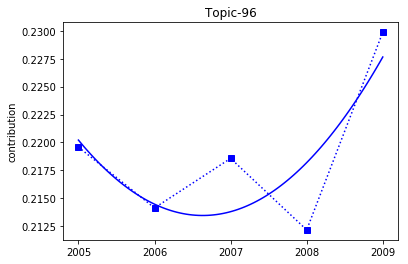

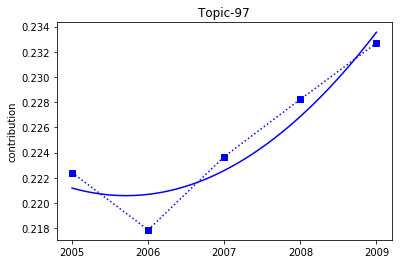

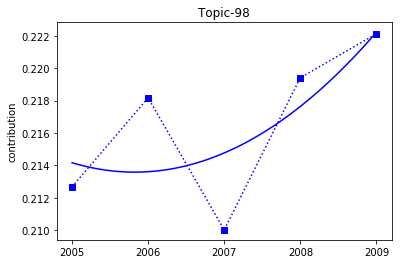

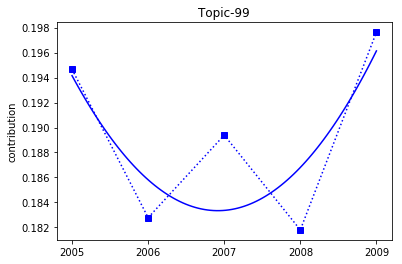

In [5]:
# create arrays of fake points
my_xticks = ['2005', '2006', '2007', '2008', '2009']
x = np.array([1, 2, 3,  4,  5])
    
# Polynomial Regression
def polyfit(x, y, degree):
    results = {}
    
    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    
    # fit values, and mean
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['p2_score'] = ssreg / sstot

    return results

#line smoothing
def smoothing(x, deg_val, k_val = 2):
    
    y = np.polyval(deg_val,x)
    x_smooth = np.linspace(x.min(), x.max(), 100)
    tck = interpolate.splrep(x, y, k=k_val)
    y_smooth = interpolate.splev(x_smooth, tck)

    return x_smooth, y_smooth

#for tid, data in grouped_year_similarity:
hot_topic_id = []
cold_topic_id = []
#topic = []
for tid, row_by_topic in grouped_topic_similarity:
    
    topic = row_by_topic.groupby(['year']).sim.mean().tolist()
    
    # fit up to deg=2
    row = polyfit(x, topic, 2)
    p2_score = row['p2_score']
    deg2 = row['polynomial']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,topic)
    #r_value > 0.80
    if p2_score > 0.90:
        
        plt.figure()
        plt.xticks(x, my_xticks)
        topic_num = tid
        x_smooth, y_smooth = smoothing(x, deg2)
        min_val = min(topic)
        if (min_val == topic[2]) and (topic[2]<topic[3]<topic[4]):
            plt.plot(x, topic, marker='s', linestyle=':', color='r', label='Square')
            plt.plot(x_smooth, y_smooth,'r-')
            hot_topic_id.append(tid)
        elif topic[0]<topic[2]<topic[3]<topic[4]:
            plt.plot(x, topic, marker='s', linestyle=':', color='r', label='Square')
            plt.plot(x_smooth, y_smooth,'r-')
            hot_topic_id.append(tid)
        elif (min_val == topic[1] or min_val == topic[2]) and (topic[2]<topic[3]<topic[4]):
            plt.plot(x, topic, marker='s', linestyle=':', color='r', label='Square')
            plt.plot(x_smooth, y_smooth,'r-')
            hot_topic_id.append(tid)
        elif deg2[0] < 0 and slope < 0:
            plt.plot(x, topic, marker='s', linestyle=':', color='b', label='Square')
            plt.plot(x_smooth, y_smooth,'b-')
            cold_topic_id.append(tid)
        elif deg2[0] < 0 and deg2[1] > 0 and r_value > 0.80:
            plt.plot(x, topic, marker='s', linestyle=':', color='b', label='Square')
            plt.plot(x_smooth, y_smooth,'b-')
            cold_topic_id.append(tid)
        elif r_value < 0.80:
            plt.plot(x, topic, marker='s', linestyle=':', color='b', label='Square')
            plt.plot(x_smooth, y_smooth,'b-')
            cold_topic_id.append(tid)
        else:
            plt.plot(x, topic, marker='s', linestyle=':', color='r', label='Square')
            plt.plot(x_smooth, y_smooth,'r-')
            hot_topic_id.append(tid)
            
        #plt.xlabel('recognition span')
        plt.ylabel('contribution')
        plt.title(tid)
    else:
        plt.figure()
        plt.xticks(x, my_xticks)
        topic_num = tid
        x_smooth, y_smooth = smoothing(x, deg2)
        
        plt.plot(x, topic, marker='s', linestyle=':', color='b', label='Square')
        plt.plot(x_smooth, y_smooth,'b-')
        cold_topic_id.append(tid)
        
        #plt.xlabel('recognition span')
        plt.ylabel('contribution')
        plt.title(tid)
        
hot_topic_id = pd.DataFrame(hot_topic_id)
hot_topic_id.to_csv(folder_path+'hot_topic_id.csv', sep=',', encoding='utf-8', header=None, index=False)
pd.DataFrame(cold_topic_id).to_csv(folder_path+'cold_topic_id.csv', sep=',', encoding='utf-8', header=None, index=False)
print("Total number of Hot topics are", len(hot_topic_id), ",all another topics can't fulfill criteria")

### select hot topics papers with their similarity and save it
### calculate paper contribution in hot topics and save it

In [ ]:
hot_topic_id = pd.read_csv(folder_path+'hot_topic_id.csv', names=['tid'])
hot_topic_id = hot_topic_id['tid'].tolist()
df_topic_similarity = pd.read_csv(folder_path+'paper-similarity-corpus.csv', names=['tid', 'pid', 'year', 'sim'])
hot_topic_similarity = df_topic_similarity.loc[df_topic_similarity['tid'].isin(hot_topic_id)]
hot_topic_similarity.to_csv(folder_path+'hot-topic-paper-similarity.csv', sep=',', encoding='utf-8', header=None, index=False)
print("success")

hot_topic_pid = list(set(hot_topic_similarity['pid']))
hot_topic_count = len(hot_topic_id)
paper_contribution_in_ht = []
for pid in hot_topic_pid:
    paper_contribution_in_ht.append([pid, (sum(hot_topic_similarity[hot_topic_similarity['pid'] == pid]['sim'])/hot_topic_count)])
paper_contribution_in_ht = pd.DataFrame(paper_contribution_in_ht)
paper_contribution_in_ht.to_csv(folder_path+'paper-contribution-in-ht.csv', sep=',', encoding='utf-8', header=None, index=False)
author_corpus_cite = pd.read_json(folder_path+'author_corpus.json', orient='records', encoding='utf8', lines=True)
print("success")

### author contribution in papers and rank it by calculating HS Score

In [23]:
wmi_aid = pd.read_csv('D:/MS CS/RS DATA/dataset/WMIRank/aid_wmirank.csv', names=['aid']).aid.tolist()
author_corpus_cite = pd.read_json(folder_path+'author_corpus.json', orient='records', encoding='utf8', lines=True)
paper_contribution_in_ht = pd.read_csv(folder_path+'paper-contribution-in-ht.csv', names=['pid', 'score'])
author_to_paper = pd.read_json(folder_path+'author_to_paper.json', orient='records', encoding='utf8', lines=True)

with open(folder_path+'author_corpus.json', 'r', encoding='utf8') as f:
    author_corpus = []
    for doc in f:
        data = json.loads(doc)
        author_to_paper_pid = list(set(author_to_paper[author_to_paper['aid'] == data['aid']]['pid']))
        author_to_paper_pid_count = len(author_to_paper_pid)
        n_citation = int(author_corpus_cite[author_corpus_cite.aid == data['aid']].n_citation)
        n_paper = int(author_corpus_cite[author_corpus_cite.aid == data['aid']].n_paper)
        data['hs_score'] = sum(paper_contribution_in_ht[paper_contribution_in_ht['pid'].isin(author_to_paper_pid)]['score'])/author_to_paper_pid_count     
        del data['p_index']
        del data['pa_index']
        author_corpus.append(data)
    f.close()
author_corpus = pd.DataFrame(author_corpus)
author_corpus.sort_values(by=['hs_score'], inplace=True, ascending=False)
author_corpus.to_json(folder_path+'hs-author-corpus.json', orient='records', lines=True)
print("success")

success


### 0-1 Normalization

In [24]:
author_corpus = pd.read_json(folder_path+'hs-author-corpus.json', orient='records', encoding='utf8', lines=True)
minScore = author_corpus.hs_score.min()
maxScore = author_corpus.hs_score.max()
norm_corpus = []
for i, rec in author_corpus.iterrows():
    rec['n_score'] = (rec.hs_score - minScore) / (maxScore - minScore)
    norm_corpus.append(rec)
    
pd.DataFrame(norm_corpus).to_json(folder_path+'hs-author-corpus.json', orient='records', lines=True)
author_corpus = pd.read_json(folder_path+'hs-author-corpus.json', orient='records', encoding='utf8', lines=True)
author_corpus.sort_values(by=['hs_score'], inplace=True, ascending=False)
print("success")

,affiliations,aid,area,authors,h_index,hs_score,n_citation,n_paper,n_score
0,[National Laboratory of Industrial Control Tec...,697271,"[support vector machine, internal model contro...",[Weimin Zhong],1,0.549356,643,16,1.000000
1,"[University of Rochester, Rochester, NY]",426649,"[design requirement, minimum power, CMOS compa...",[Guoqing Chen],4,0.494854,658,5,0.900789
2,"[University of Southampton, Southampton, UK]",288885,"[competitive environment, reputation informati...",[Jigar Patel],15,0.489388,916,43,0.890840
3,"[Internet Computing Lab, Dept. of Computer Sci...",710516,"[wireless sensor network, MAC protocol, home n...",[Tae-Seok Lee],1,0.458062,405,7,0.833816
4,[Institute of Intelligent Information Processi...,673754,"[final segmentation result, unsupervised image...",[Qiang Sun],3,0.436427,251,4,0.794434


###  Dummy Testing Code

In [ ]:
#https://www.statisticshowto.datasciencecentral.com/kendalls-tau/
wmi_aid = pd.read_csv('D:/MS CS/RS DATA/dataset/WMIRank/aid_wmirank.csv', names=['aid']).aid.tolist()
author_corpus_cite = pd.read_json(folder_path+'author_corpus.json', orient='records', encoding='utf8', lines=True)
paper_contribution_in_ht = pd.read_csv(folder_path+'paper-contribution-in-ht.csv', names=['pid', 'score'])
author_to_paper = pd.read_json(folder_path+'author_to_paper.json', orient='records', encoding='utf8', lines=True)

with open(folder_path+'author_corpus.json', 'r', encoding='utf8') as f:
    author_corpus = []
    for doc in f:
        data = json.loads(doc)
        author_to_paper_pid = list(set(author_to_paper[author_to_paper['aid'] == data['aid']]['pid']))
        author_to_paper_pid_count = len(author_to_paper_pid)
        n_citation = int(author_corpus_cite[author_corpus_cite.aid == data['aid']].n_citation)
        n_paper = int(author_corpus_cite[author_corpus_cite.aid == data['aid']].n_paper)
        if data['aid'] in wmi_aid:
            data['hs_score'] = (sum(paper_contribution_in_ht[paper_contribution_in_ht['pid'].isin(author_to_paper_pid)]['score'])*4)/(author_to_paper_pid_count)
        elif (n_citation/n_paper)>15:
            data['hs_score'] = sum(paper_contribution_in_ht[paper_contribution_in_ht['pid'].isin(author_to_paper_pid)]['score'])/author_to_paper_pid_count
        else:
            data['hs_score'] = sum(paper_contribution_in_ht[paper_contribution_in_ht['pid'].isin(author_to_paper_pid)]['score'])/(author_to_paper_pid_count*2)      
        del data['p_index']
        del data['pa_index']
        author_corpus.append(data)
    f.close()
author_corpus = pd.DataFrame(author_corpus)
author_corpus.sort_values(by=['hs_score'], inplace=True, ascending=False)
author_corpus.to_json(folder_path+'hs-author-corpus.json', orient='records', lines=True)
print("success")

author_corpus = pd.read_json(folder_path+'hs-author-corpus.json', orient='records', encoding='utf8', lines=True)
minScore = author_corpus.hs_score.min()
maxScore = author_corpus.hs_score.max()
norm_corpus = []
for i, rec in author_corpus.iterrows():
    rec['n_score'] = (rec.hs_score - minScore) / (maxScore - minScore)
    norm_corpus.append(rec)
    
pd.DataFrame(norm_corpus).to_json(folder_path+'hs-author-corpus.json', orient='records', lines=True)
author_corpus = pd.read_json(folder_path+'hs-author-corpus.json', orient='records', encoding='utf8', lines=True)
author_corpus.sort_values(by=['hs_score'], inplace=True, ascending=False)
print("success")